# EMCrafter
This summarized notebook covers how one can generate large-scale simulations. To a robust understanding
of the functions and subclasses, please refer to our TUTORIAL, that contains a deep explanation about:
- OrientationSampling: Create random orientations
- DefocusSampling: Create random defocus that follows experimental data distribution
- NoiseShape: How to build Noise that follows real-space experimental distribution
- NoiseFrequency: How to modulate Noise so that it presents the same frequency dependence of the experimental data
- NoiseGenerator: Wrapper class that generates Noise automatically based on shape and frequency
- SignalNoiseRatio: How to build and Noise scaler
- SignalGeneration: How to simulate the clean signal from a PDB
- FullSimulation: Create small and large-scale synthetic datasets using all previous described classes
- ExportSTAR: Export the simulation in a format that can be imported to mainstream cryoEM processing software

## Load Library

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd()) + "/../src")

import EMCrafter
from EMCrafter.sim import ParticleSimulator
from EMCrafter.sampler import OrientationSampler, DefocusSampler
EMCrafter.base._set_logging(minimal=True)

## Instantiate Simulator and Dependencies

In [2]:
# Instantiate Simulator
pSimulator = ParticleSimulator()

In [3]:
# Load classes
pkl_dir = "../TUTORIAL/data/pickle"
pSimulator.signal = pSimulator.signal.load(f"{pkl_dir}/signal_generator.pkl")
pSimulator.noise  = pSimulator.noise.load(f"{pkl_dir}/noise_generator.pkl")
pSimulator.snr    = pSimulator.snr.load(f"{pkl_dir}/snr.pkl")

Loaded SignalGenerator object from ../TUTORIAL/data/pickle/signal_generator.pkl
Loaded NoiseGenerator object from ../TUTORIAL/data/pickle/noise_generator.pkl
Loaded SNR object from ../TUTORIAL/data/pickle/snr.pkl


In [4]:
# Load our orientation and defocus samplers
orient_sampler  = OrientationSampler().load(f"{pkl_dir}/orientation_sampler.pkl")
defocus_sampler = DefocusSampler().load(f"{pkl_dir}/defocus_sampler.pkl", validate=False)

Loaded OrientationSampler object from ../TUTORIAL/data/pickle/orientation_sampler.pkl
Loaded DefocusSampler object from ../TUTORIAL/data/pickle/defocus_sampler.pkl


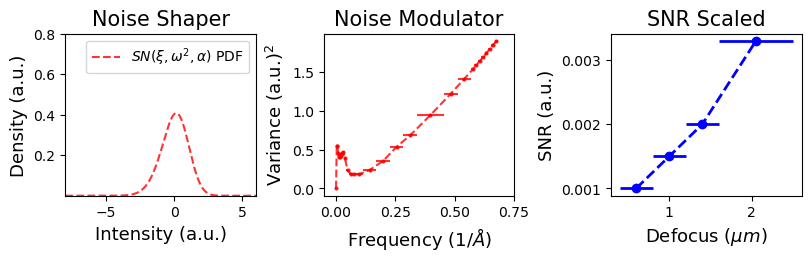

In [5]:
# Check summary
pSimulator.info()

## Create the synthetic dataset

In [6]:
# Setup
n_particles = 100  # Number of particles to simulate in this example
n_cpus = 10        # Number of CPUs for parallel computing
chunk_size = 10    # Since this is a small example, we set the chunk size to 10
                   # but for large scale simulations, set it to 100-200. Batch
                   # size is the number of simulated particles per division.

# Sample
angles  = orient_sampler.sample(n_particles)
defocus = defocus_sampler.sample(n_particles)

# Simulate
sim = pSimulator.simulate_dataset(
    angles,                       # Sampled orientations
    defocus,                      # Sampled defocus
    n_cpus=n_cpus,                # Parallelization
    chunk_size=chunk_size,        # Number of simulated particles per job
    output="data/sim_particles",  # Output directory
    use_eman=True                 # Wether to project densities using EMAN2 framework
)  

Starting 'simulate_dataset'...
Simulating 100 particles distributed in 10 chunks of size 10...
Simulating: 100%|███████████████████████████████| 10/10 [00:54<00:00,  5.46s/it]
Finished 'simulate_dataset' in 55.26s.


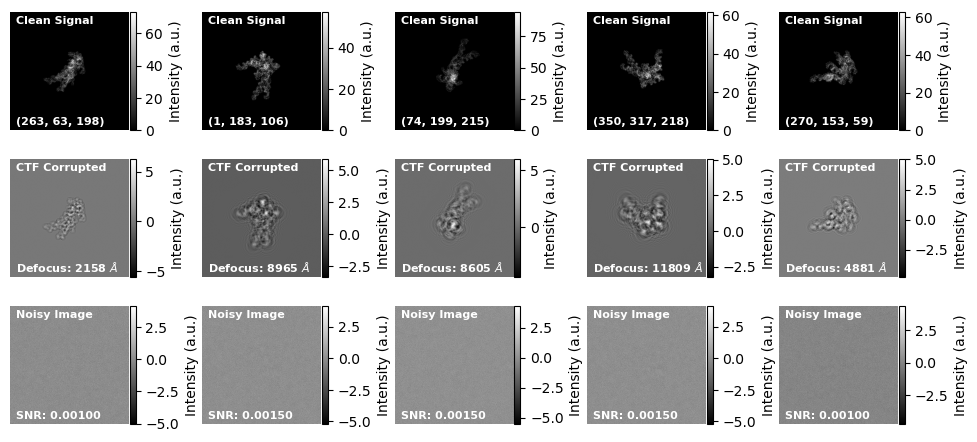

In [7]:
# Visualization
fig = sim.plot()

In [8]:
# To save this dataset, use:
sim.save("data/sim_dataset.pkl")

## Export simulation
This generates the organized structure of files tha makes it feasible to import into RELION, cryoSPARC and others

In [9]:
# Output folder containing the relion project structure:
export_output = "data/rln_project"  

# Export type:
export_type   = "link"
# Export type needs to be one of ["copy", "move", "link"]
# - copy: copy the particle files into this relion project
# - move: move the particle files into this relion project, but then
#         the simulation will not be able to read those files anymore
# - link: uses symlink so it does not need to copy/move anything (recomended)

# Exporting:
df = sim.export_particles(
    export_output,          # Output folder
    export_type,            # Type of file building
    force=True)             # If the folder already exists, you need force=True for overriding
# The output 'df' is a pandas DataFrame related to the star file.
# To import the simulation into cryoSPARC or RELION, please refer to the TUTORIAL.

Starting 'export_particles'...
Output directory exists, existing files may be overwritten.
Output directory set to: data/rln_project.
> Export: Validate arguments
> Export: Format optics
> Export: Format particles
> Export: Build physical files
> Export: Compile STAR file
Finished 'export_particles' in 0.19s.
